In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

# Semantic Segmentation for Buildings and Solar Panels

This notebook demonstrates training semantic segmentation models for buildings and solar panels in aerial imagery using labels from OpenStreetMap (OSM).

In [32]:
import os
from pathlib import Path

import argparse
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import pandas as pd
import pickle
import rasterio
from rasterio.plot import show


## Data Acquisition

The data in this demo was sourced from OpenAerialMap and OpenStreetMap (OSM). We used aerial imagery from OpenAerialMap, specifically the scene named `Kalobeyei_2B_Flight_03`. The scene was divided into a train/validation section and a test section.

We queried OpenStreetMap (OSM) data using the `osmnx` library to obtain the following features:
- **Buildings**: Identified by the tag `"building" = True`.
- **Solar Panels**: Identified by the tag `"generator:source" = "solar"`.
- **Toilets**: Identified by the tag `"amenity" = "toilets"`.

## Data Preparation
Once the data were downloaded, we prepared it through the following steps:

1. **Toilet Features**: 
   - Converted toilet features from point data to polygon data using a buffer operation to create a more accurate representation.

2. **Merging Polygons**: 
   - Combined the toilet polygons with the building and solar panel polygons to create a unified dataset.

3. **Manual Alignment**: 
   - Realigned the polygons to match the aerial imagery scene accurately, ensuring that the annotations align with the visual data.

4. **Drawing Background Polygons**:
   - Manually drew polygons to represent background areas that do not contain any buildings, solar panels, or toilets.

5. **Annotations**: 
   - Saved the processed annotations into two files:
     - **Raw Annotations**: Stored in `osm_buildings-toilets-solar_aligned.geojson`.
     - **Background Polygons**: Stored in `background_polygons.geojson`.

In [16]:
RAW_DATA_DIR = './data/raw'
INTERIM_DATA_DIR = './data/interim'
PROCESSED_DATA_DIR = './data/processed'

TRAINVAL_IMAGE_FILE = f'{RAW_DATA_DIR}/images/trainval_Kalobeyei_2B_Flight_03.tif'
TEST_IMAGE_FILE = f'{RAW_DATA_DIR}/images/test_Kalobeyei_2B_Flight_03.tif'

ANNOTATIONS_FILE = f'{RAW_DATA_DIR}/annotations/osm_buildings-toilets-solar_aligned.geojson'
BACKGROUND_ANNOTATIONS_FILE = f'{RAW_DATA_DIR}/annotations/background_polygons.geojson'

Let's create footprint shapefiles for the train/validation and test imagery files to quickly visualize our data. Note that while we could also plot the imagery itself, this process takes significantly longer to run.

In [17]:
footprints_dir = f'{INTERIM_DATA_DIR}/image_footprints/'
os.makedirs(footprints_dir, exist_ok=True)

for image_file in [TRAINVAL_IMAGE_FILE, TEST_IMAGE_FILE]:
    output_file = os.path.join(footprints_dir, os.path.basename(image_file).replace('.tif', '_footprint.shp'))
    command = f"python ../scripts/data_preprocessing/get_raster_footprint.py -f {image_file} -o {output_file}"
    print(command)
    !{command}


python ../scripts/data_preprocessing/get_raster_footprint.py -f ./data/raw/images/trainval_Kalobeyei_2B_Flight_03.tif -o ./data/interim/image_footprints/trainval_Kalobeyei_2B_Flight_03_footprint.shp
DEBUG:root:gdalwarp -dstnodata 0 -dstalpha -of GTiff data/raw/images/trainval_Kalobeyei_2B_Flight_03.tif data/raw/images/trainval_Kalobeyei_2B_Flight_03_alphaband.tif
Using band 4 of source image as alpha.
Creating output file that is 20350P x 30081L.
Processing data/raw/images/trainval_Kalobeyei_2B_Flight_03.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
DEBUG:root:gdal_polygonize.py data/raw/images/trainval_Kalobeyei_2B_Flight_03_alphaband.tif -b 4 -f ESRI Shapefile data/interim/image_footprints/trainval_Kalobeyei_2B_Flight_03_footprint.shp
Creating output data/interim/image_footprints/trainval_Kalobeyei_2B_Flight_03_footprint.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.
python ../scripts/data_preprocessing/get_raster

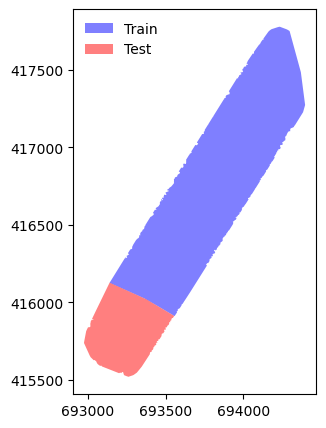

In [18]:
# Plot the footprints
fig, ax = plt.subplots(figsize=(5, 5))

for image_file, color in zip([TRAINVAL_IMAGE_FILE, TEST_IMAGE_FILE], ['blue', 'red']):
    footprint_file = os.path.join(footprints_dir, os.path.basename(image_file).replace('.tif', '_footprint.shp'))
    extent = gpd.read_file(footprint_file)
    extent.plot(ax=ax, facecolor=color, alpha=0.5, edgecolor='none', linewidth=2)

# Create custom legend
train_patch = mpatches.Patch(facecolor='blue', alpha=0.5, edgecolor='none', label='Train')
test_patch = mpatches.Patch(facecolor='red', alpha=0.5, edgecolor='none', label='Test')
plt.legend(handles=[train_patch, test_patch], loc='upper left', frameon=False)

plt.show()

## Semantic Segmentation Mask Preparation
Next, we'll prepare the annotations to easily generate segmentation masks. We'll use the `collect_annotations.py` script from this repository, which performs the following tasks:
- Extracts building and solar panel polygons from the annotations.
- Creates building boundary polygons by applying a buffer to the exterior of each building polygon.

In [19]:
# Collect the annotations that will be used for semantic segmentation masks
ANNOTATIONS_FILE = f'{RAW_DATA_DIR}/annotations/osm_buildings-toilets-solar_aligned.geojson'
polygon_annotations_file = f'{INTERIM_DATA_DIR}/annotations/{os.path.basename(ANNOTATIONS_FILE).replace(".geojson", "_polygons.geojson")}'
output_file = f'{INTERIM_DATA_DIR}/semantic_segmentation_classes.gpkg'

# Construct the command
command = (
    f"python ../scripts/semantic_segmentation/collect_annotations.py "
    f"--object-annotations {ANNOTATIONS_FILE} "
    f"--polygon-annotations {polygon_annotations_file} "
    f"--background-annotations {BACKGROUND_ANNOTATIONS_FILE} "
    f"--save-path {output_file}"
)
# Run the command
print(command)
!{command}


python ../scripts/semantic_segmentation/collect_annotations.py --object-annotations ./data/raw/annotations/osm_buildings-toilets-solar_aligned.geojson --polygon-annotations ./data/interim/annotations/osm_buildings-toilets-solar_aligned_polygons.geojson --background-annotations ./data/raw/annotations/background_polygons.geojson --save-path ./data/interim/semantic_segmentation_classes.gpkg
100%|████████████████████████████████████| 3549/3549 [00:00<00:00, 17242.64it/s]


In [20]:
# Create the masks
for image_file in [TRAINVAL_IMAGE_FILE, TEST_IMAGE_FILE]:
    output_file = os.path.join(
        INTERIM_DATA_DIR,
        'unclipped_masks',
        os.path.basename(image_file)
    )
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    label_file = f'{INTERIM_DATA_DIR}/semantic_segmentation_classes.gpkg'
    label_column = 'class'
    label_order = ["background", "building", "building_boundary", "solar"]
    label_order_cli = ' '.join(label_order)
    command = f"python ../scripts/semantic_segmentation/create_mask.py -i {image_file} -l {label_file} --label-column {label_column} -o {output_file} --label-order {label_order_cli}"
    print(command)
    !{command}

python ../scripts/semantic_segmentation/create_mask.py -i ./data/raw/images/trainval_Kalobeyei_2B_Flight_03.tif -l ./data/interim/semantic_segmentation_classes.gpkg --label-column class -o ./data/interim/unclipped_masks/trainval_Kalobeyei_2B_Flight_03.tif --label-order background building building_boundary solar


gdal_rasterize -q -ot Byte -a_nodata 0 -init 0 -burn 1 -of GTiff -co TILED=YES -co BLOCKXSIZE=512 -co BLOCKYSIZE=512 -co INTERLEAVE=PIXEL -where class='background' -te 693138.2784 415911.6873 694401.9754 417779.6689 -ts 20350 30081 -co COMPRESS=LZW -co PREDICTOR=2 -co BIGTIFF=YES ./data/interim/semantic_segmentation_classes.gpkg ./data/interim/unclipped_masks/trainval_Kalobeyei_2B_Flight_03.tif
Mask file ./data/interim/unclipped_masks/trainval_Kalobeyei_2B_Flight_03.tif created with class 0 (nodata) and 1 (background)
gdal_rasterize -q -b 1 -burn 2 -where class='building' ./data/interim/semantic_segmentation_classes.gpkg ./data/interim/unclipped_masks/trainval_Kalobeyei_2B_Flight_03.tif
Class 2 (building) added to mask.
gdal_rasterize -q -b 1 -burn 3 -where class='building_boundary' ./data/interim/semantic_segmentation_classes.gpkg ./data/interim/unclipped_masks/trainval_Kalobeyei_2B_Flight_03.tif
Class 3 (building_boundary) added to mask.
gdal_rasterize -q -b 1 -burn 4 -where class='s

In [21]:
# Clip masks to the footprints using gdalwarp cutline
for image_file in [TRAINVAL_IMAGE_FILE, TEST_IMAGE_FILE]:
    mask_file = os.path.join(
        INTERIM_DATA_DIR,
        'unclipped_masks',
        os.path.basename(image_file)
    )
    footprint_file = os.path.join(footprints_dir, os.path.basename(image_file).replace('.tif', '_footprint.shp'))
    output_file = os.path.join(
        RAW_DATA_DIR,
        'semantic_segmentation',
        'masks',
        os.path.basename(image_file)
    )
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    command = f"gdalwarp -cutline {footprint_file} -crop_to_cutline {mask_file} {output_file}"
    print(command)
    !{command}


gdalwarp -cutline ./data/interim/image_footprints/trainval_Kalobeyei_2B_Flight_03_footprint.shp -crop_to_cutline ./data/interim/unclipped_masks/trainval_Kalobeyei_2B_Flight_03.tif ./data/raw/semantic_segmentation/masks/trainval_Kalobeyei_2B_Flight_03.tif
Creating output file that is 20301P x 30039L.
Processing ./data/interim/unclipped_masks/trainval_Kalobeyei_2B_Flight_03.tif [1/1] : 0Using internal nodata values (e.g. 0) for image ./data/interim/unclipped_masks/trainval_Kalobeyei_2B_Flight_03.tif.
Copying nodata values from source ./data/interim/unclipped_masks/trainval_Kalobeyei_2B_Flight_03.tif to destination ./data/raw/semantic_segmentation/masks/trainval_Kalobeyei_2B_Flight_03.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
gdalwarp -cutline ./data/interim/image_footprints/test_Kalobeyei_2B_Flight_03_footprint.shp -crop_to_cutline ./data/interim/unclipped_masks/test_Kalobeyei_2B_Flight_03.tif ./data/raw/semantic_segmentation/masks/test_Kalobeyei_2B_Flight_03.tif
C

## Sampling Chips for Semantic Segmentation Dataset

In this step, we extract smaller image chips from our paired imagery and mask scenes to create a dataset for training our model. Pre-sampling these chips allows us to balance the dataset, ensuring that small features (such as solar panels), which occupy a relatively small area in the scenes, are adequately represented.

In [25]:
import scripts.semantic_segmentation.sample_chips
from scripts.semantic_segmentation.sample_chips import _filter_dataframe, _sample_diverse_values, _sample_points_from_footprints
from src.geo_utils import exclude_points_within_buffer

def _get_candidate_points(seed):
    """
    Helper function to get candidate points for chip sampling.
    It loads all polygon annotations and filters for solar and building polygons. Then,
    it removes building polygons that contain solar polygons (since these will already
    be included in the solar polygons). Next, it subsamples a diverse set of building
    polygons (since there are many more building polygons than solar polygons). Then,
    it gets centroids of these solar and building polygons.

    To get background points, it samples points from footprints and also loads
    manually-selected background points. It combines the footprint points and manual
    points, making sure to exclude points that are too close to solar or building
    centroids.

    Returns:
    tuple: A tuple containing the solar points, building points, and background points.
    """
    print("Getting candidate points for chip sampling...")
    POLYGON_ANNOTATIONS_PATH = (polygon_annotations_file)
    FOOTPRINT_PATHS = [
        "./data/interim/image_footprints/trainval_Kalobeyei_2B_Flight_03_footprint.shp",
        "./data/interim/image_footprints/test_Kalobeyei_2B_Flight_03_footprint.shp",
    ]
    BACKGROUND_ANNOTATIONS_PATHS = []
    DATA_CRS = "EPSG:32636"

    # Load all polygon annotations
    polygons = gpd.read_file(POLYGON_ANNOTATIONS_PATH).to_crs(DATA_CRS)

    # Filter for solar and building polygons
    solar_conditions = {
        "power": lambda x: x == "generator",
        "generator:source": lambda x: x == "solar",
    }
    building_conditions = {"building": lambda x: ~x.isna()}

    solar = _filter_dataframe(polygons, solar_conditions)
    bldg = _filter_dataframe(polygons, building_conditions)
    print(f"Number of SOLAR polygons: {len(solar)}")

    # Get building polygons that do NOT contain solar polygons
    bldg_contains_solar = gpd.sjoin(
        bldg, solar, how="inner", predicate="contains"
    )
    bldg_no_solar = bldg[~bldg.index.isin(bldg_contains_solar.index)].copy()

    # Subsample diverse set of building polygons
    bldg_no_solar = _sample_diverse_values(
        bldg_no_solar, "building", num_to_sample=150, seed=seed
    )
    print(f"Number of BUILDING polygons: {len(bldg_no_solar)}")

    # Get centroids of solar and building polygons
    solar["geometry"] = solar.centroid
    bldg_no_solar["geometry"] = bldg_no_solar.centroid

    # Sample points from footprints
    footprint_points = _sample_points_from_footprints(
        FOOTPRINT_PATHS, DATA_CRS, num_to_sample=400, seed=seed
    )
    # # Load manually-selected background points
    # manual_points = concat_geo_files(BACKGROUND_ANNOTATIONS_PATHS, DATA_CRS)
    # # Combine footprint points and manual points
    # background = pd.concat([footprint_points, manual_points]).reset_index(
    #     drop=True
    # )
    background = footprint_points
    background["background_idx"] = background.index
    # Exclude points that are too close to solar or building centroids
    background = exclude_points_within_buffer(
        background, pd.concat([solar, bldg_no_solar]), 20
    )
    print(f"Number of BACKGROUND points: {len(background)}")

    return solar, bldg_no_solar, background

scripts.semantic_segmentation.sample_chips._get_candidate_points = _get_candidate_points

args = argparse.Namespace(
    seed=42,
    chip_size=256,
    input_imagery_dir = f'{RAW_DATA_DIR}/images',
    input_mask_dir = f'{RAW_DATA_DIR}/semantic_segmentation/masks',
    chip_output_dir = f'{PROCESSED_DATA_DIR}/chipped_datasets/semantic_segmentation',
    chip_locations_save_path = f'{INTERIM_DATA_DIR}/semantic_segmentation/chip_locations.gpkg',
)
scripts.semantic_segmentation.sample_chips.sample_chips(args)

Getting candidate points for chip sampling...
Number of SOLAR polygons: 141
Number of BUILDING polygons: 358
Number of BACKGROUND points: 303
Getting valid chip extents from candidate points...


100%|██████████| 2/2 [00:11<00:00,  5.59s/it]


53
Number of candidate chips: 159
	- candidate solar chips: 53
	- candidate building chips: 53
	- candidate background chips: 53
Cropping imagery and masks to chips...


100%|██████████| 159/159 [00:13<00:00, 12.10it/s]

Number of rows to remove: 0
159


## Model Training

Now, we will train the model on the prepared dataset for a few epochs. After training, we will visualize the model's predictions on the test image chips to qualitatively examine its performance.

In [30]:
# Train the model
output_dir = './outputs'
chip_dir = f'{PROCESSED_DATA_DIR}/chipped_datasets/semantic_segmentation/images'
mask_dir = f'{PROCESSED_DATA_DIR}/chipped_datasets/semantic_segmentation/masks'
tile_split_file = './config/dataset_splits.yml'
command = (
    f"python ../scripts/semantic_segmentation/train.py "
    "--exp-version demo "
    f"--chip-dir {chip_dir} "
    f"--mask-dir {mask_dir} "
    f"--tile-split-file {tile_split_file} "
    f"--output-dir {output_dir} "
    "--max-epochs 5 "
)
print(command)
!{command}

python ../scripts/semantic_segmentation/train.py --exp-version demo --chip-dir ./data/processed/chipped_datasets/semantic_segmentation/images --mask-dir ./data/processed/chipped_datasets/semantic_segmentation/masks --tile-split-file ./config/dataset_splits.yml --output-dir ./outputs --max-epochs 5 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: outputs/semantic_segmentation/demo-2024-09-16-23-13-14/logs/lightning_logs/tb_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Unet             | 32.0 M
1 | loss          | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
32.0 

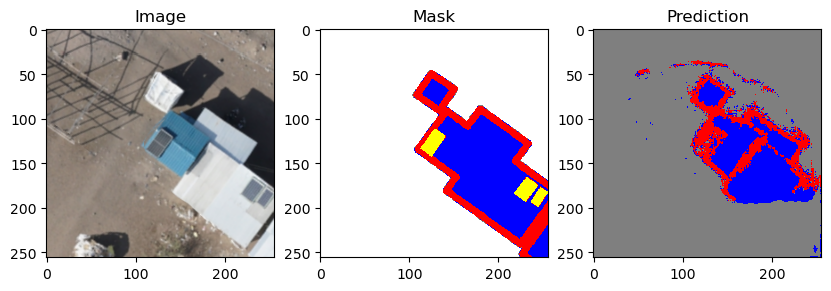

In [34]:
# Load chip predictions
segmentation_cmap = colors.ListedColormap(
    [(1,1,1), (0.5, 0.5, 0.5), (0,0,1), (1,0,0), (1,1,0)]
)
chip_preds_f = Path('./outputs/semantic_segmentation/demo-2024-09-16-23-13-14/epoch=4-step=20_chip_inference.pkl')
with chip_preds_f.open('rb') as f:
    chip_preds = pickle.load(f)

# Get the first item from the test chips
chip_path, chip_pred = list(chip_preds['test_chips'].items())[0]

# Load the chip image
chip_rel_path = chip_path.relative_to('./')
with rasterio.open(chip_rel_path) as ds:
    chip_img = ds.read()[0:3].transpose(1, 2, 0)

# Load the mask image
mask_path = Path(*[part if part != 'images' else 'masks' for part in chip_rel_path.parts])
with rasterio.open(mask_path) as ds:
    mask_img = ds.read().squeeze()

# Plot the image, mask, and prediction
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(chip_img)
ax[0].set_title('Image')
ax[1].imshow(mask_img, cmap=segmentation_cmap, vmin=0, vmax=4)
ax[1].set_title('Mask')
ax[2].imshow(chip_pred, cmap=segmentation_cmap, vmin=0, vmax=4)
ax[2].set_title('Prediction')
plt.show()

In a real-world scenario, we would train the model on a larger dataset and for many more epochs. For this demo, let's run inference using a pre-trained model checkpoint and examine the predictions.

In [36]:
checkpoint = './epoch=17-step=1224.ckpt'
image_dir = './data/raw/images'
output_dir = './outputs/semantic_segmentation/demo-2024-09-16-23-13-14/inference'
device = 'cuda:0'

command = (
    f"python ../scripts/semantic_segmentation/inference.py "
    f"--checkpoint {checkpoint} "
    f"--image-dir {image_dir} "
    f"--output-dir {output_dir} "
    f"--device {device}"
)
print(command)
!{command}

python ../scripts/semantic_segmentation/inference.py --checkpoint ./epoch=17-step=1224.ckpt --image-dir ./data/raw/images --output-dir ./outputs/semantic_segmentation/demo-2024-09-16-23-13-14/inference --device cuda:0
/opt/conda/envs/turkana-camp-roof-mapping/lib/python3.10/site-packages/torchgeo/trainers/segmentation.py:113: UserWarning: ignore_index has no effect on training when loss='jaccard'
  warnings.warn(
Input size: 9803 x 9380
100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.38it/s]
Finished running model in: 6.62 seconds
Finished saving predictions in: 0.55 seconds
Input size: 30081 x 20350
100%|█████████████████████████████████████████| 192/192 [00:35<00:00,  5.45it/s]
Finished running model in: 35.21 seconds
Finished saving predictions in: 3.58 seconds


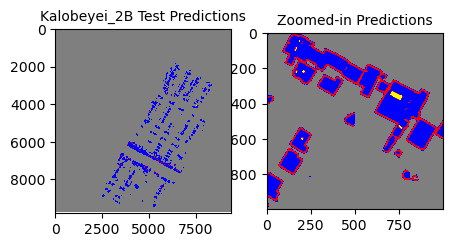

In [43]:
# Load scene predictions
scene_preds_f = './outputs/semantic_segmentation/demo-2024-09-16-23-13-14/inference/epoch=17-step=1224_test_Kalobeyei_2B_Flight_03.tif'
with rasterio.open(scene_preds_f) as src:
    scene_preds = src.read().squeeze()

fig, ax = plt.subplots(1, 2, figsize=(5, 25))
# Plot the entire scene predictions
ax[0].imshow(scene_preds, cmap=segmentation_cmap, vmin=0, vmax=4)
ax[0].set_title('Kalobeyei_2B Test Predictions', fontsize=10)
# Plot a zoomed in section of the predictions
ax[1].imshow(scene_preds[7000:8000, 4000:5000], cmap=segmentation_cmap, vmin=0, vmax=4)
ax[1].set_title('Zoomed-in Predictions', fontsize=10)
plt.show()
